In [1]:
%matplotlib inline
%load_ext memory_profiler 
# pip install memory_profiler

In [2]:
from KnackpackData import n_items,weights,values,max_weight,getDiff
from Timer import *
import matplotlib.pyplot as plt
import numpy as np
import random
t = Timer()

## Simulated Annealing

Simulated Annealing (SA) jest stochastycznym algorytmem do znajowania globalnych ekstremówó w dużyc problemach optymalizacyjnych. Wykorzystuje się go bardzo często w problemach optymalizacji wartości dyskretnych.

SA przy każdej iteracji generuje nowy stan, bazujący na obecnym, w którym zmienia losowo jeden bit. Następnie porównywane są wartości nowego i obecnego stanu. Jeżeli wartości nwoego stanu są lepsze od poprzedniego i są akceptowalne (nie przekraczają limitu wagi) są akceptowane. Jeżeli nowo wygenerowany stan jest błędny, poniewaz przykładowo przekracza maksymalną wagę to wciąż może zostać wykorzystany w następnej iteracji w pewnym prawdopodobieństwem. Takie podejście pozwala algorytmowi uciekać z minimów lokalnych.

Do poprawnej pracy algorytmu definiuje się stan początkowy jako pusty plecak oraz parametry wyżarzania, na podsawie których osiągany jest warunek stopu.

In [3]:
class SimulatedAnnealing:
    def __init__(self, initial_temp = 1000, alpha = 0.999, frozen_level = 0.1, n_items = 16, values = [], weights = [], max_weight = 3):
        self.initial_temp = initial_temp
        self.alpha = alpha
        self.frozen_level = frozen_level
        self.n_items = n_items
        self.values = values
        self.weights = weights
        self.max_weight = max_weight
        
    def setInitialValues(self):
        '''Wyzeruj tablice wyników oraz ustaw wartości początkowe.'''
        
        # Stan początkowy jest po prostu pustym plecakiem.
        self.initial_state = np.zeros(self.n_items).astype(bool)
        self.best_state = self.initial_state
        self.current_state = self.initial_state
        
        self.temperature = self.initial_temp

        # Tablice wyników zawierają tylko zerowy stan.
        self.scores_table = [np.sum(self.values[self.initial_state])]
        self.best_scores_table = [np.sum(self.values[self.initial_state])]
        self.best_value_index = 0
    
    def run(self):
        if self.temperature is None:
            self.setInitialValues()
            
        it = 0
        while self.temperature > self.frozen_level:
            it += 1
            # Generate next state
            next_state = np.copy(self.current_state)
            idx = np.random.randint(0,self.n_items) # get random index to flip
            next_state[idx] = 1 - next_state[idx] # flip generated index

            self.scores_table.append(np.sum(self.values[next_state]))

            # Calculate delta (if next state is better than current)
            delta = np.sum(self.values[next_state]) - np.sum(self.values[self.current_state])

            if delta > 0 and np.sum(self.weights[next_state]) <= self.max_weight:
                # If next state is better than current - set this state as current
                self.current_state = np.copy(next_state)

                # If new state is better than the best - set this state as best
                if np.sum(self.values[self.current_state]) > np.sum(self.values[self.best_state]):
                    self.best_state = np.copy(self.current_state)
                    self.best_value_index = it
                    self.best_scores_table.append(np.sum(self.values[self.best_state]))
            else:
                # If the new solution is not better, accept it with a probability of e^(-delta/temp)
                acceptance_function = np.exp(-delta / self.temperature)
                if acceptance_function > random.uniform(0, 1):
                    self.current_state = np.copy(next_state)

            self.temperature *= self.alpha
        
    def results(self):
        best_value = np.sum(self.values[self.best_state])
        best_weight = np.sum(self.weights[self.best_state])
        print("Best value: ",best_value)
        print("Best weight: ",best_weight)
        print("Difference (value, weight):", getDiff(n_items,best_value, best_weight))
        
    def plot_results(self, plot = 'best_of_all'):
        if plot == 'best_of_all':
            plt.figure(figsize=(16, 12), dpi=80)
            plt.scatter(self.best_value_index, np.array(self.scores_table)[self.best_value_index], color="r", s=200, zorder=2)
            plt.plot(np.arange(np.array(self.scores_table).size), np.array(self.scores_table), color="b", zorder=1)
            plt.title('Value changes')
        elif plot == 'best_changes':
            plt.figure(figsize=(16, 12), dpi=80)
            plt.plot(np.arange(np.array(self.best_scores_table).size), np.array(self.best_scores_table), color="b")
            plt.title('Best results changes')
            
        plt.ylabel('Value')
        plt.xlabel('Iteration')
        plt.show()

In [4]:
SA = SimulatedAnnealing(1000, 0.999, 0.1, 16, values, weights, max_weight)
SA.setInitialValues()
t.start()
SA.run()
t.stop()
SA.results()

Elapsed time: 0.3699 seconds.
Best value:  4.996682595542677
Best weight:  2.895318158076152
Difference (value, weight): [4.457322511086659e-09, 1.923848191864863e-09]


## Visualisations

### Best value in all data

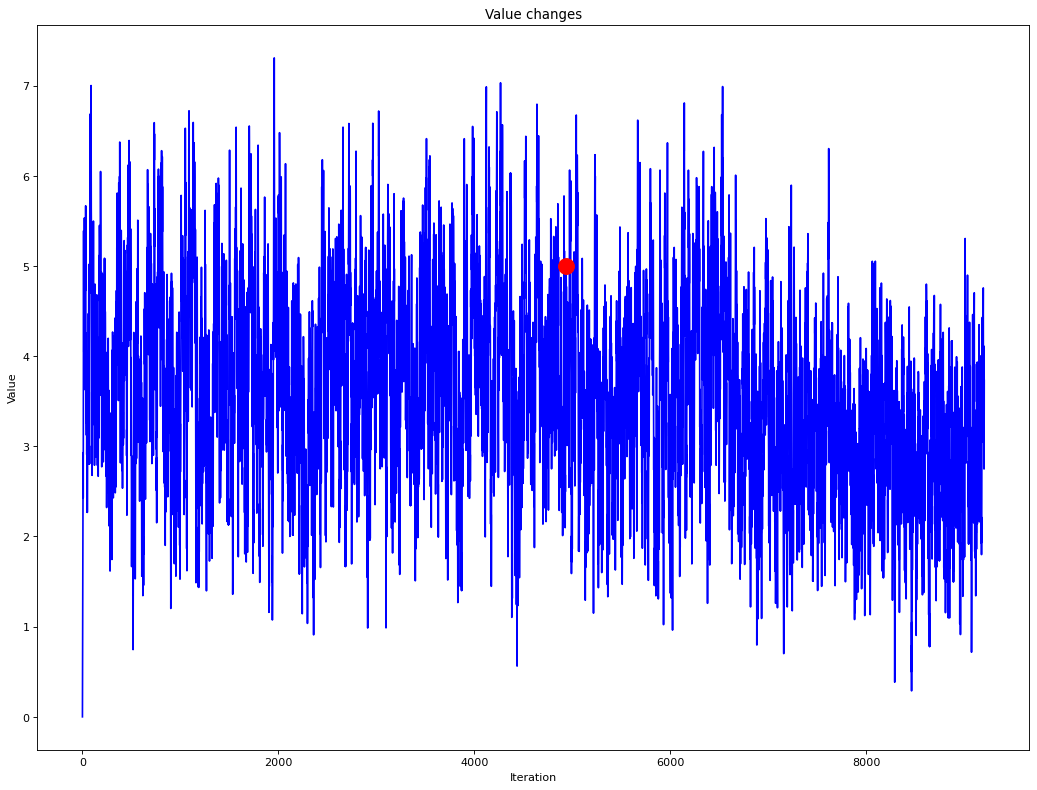

In [5]:
SA.plot_results()

### Best values change plot

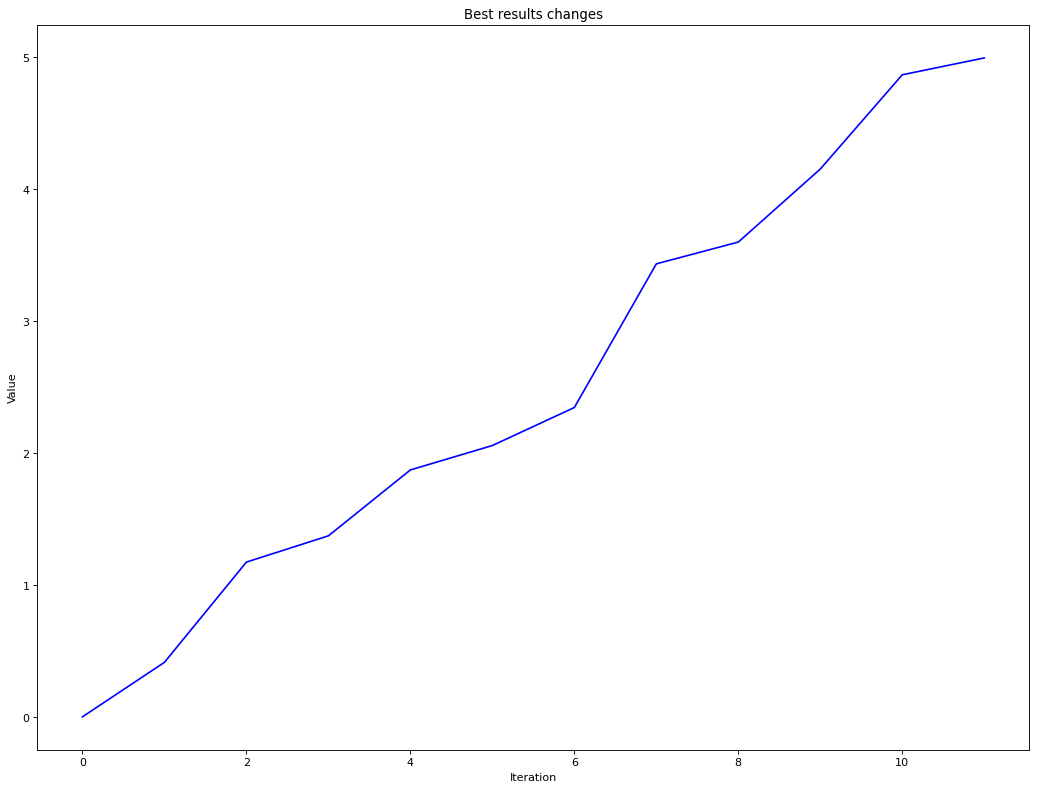

In [6]:
SA.plot_results(plot='best_changes')

## Wnioski

Podana implementacja algorytmu Simulated Annealing z zdanymi parametrami nie znalazła minimum globalnego dla przeszukiwanego zbioru danych, jednakże pokazuje, że algorytm ma potencjał na szukanie minimów globlanych dzięki temu, że potarfi uciekać z minimów lokalnych i lepiej eksplorować cały przeszukiwany obszar. 

Należałoby poszukać jak najlepszych parametrów, które dadzą dobre wyniki. Połączenie z algorytmem genetycznym pozwoli na lepszą eksploatację.